## Imports

In [ ]:
import os
os.environ["ITK_GLOBAL_DEFAULT_NUMBER_OF_THREADS"] = "32"
import warnings
warnings.filterwarnings('ignore')

import ants
import time
import glob
import keras
import imageio
import numpy as np
import random as rd
import pandas as pd
import pickle as pkl
import seaborn as sns
import tensorflow as tf
from iaflow import IAFlow
from keras import callbacks
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image as PreImage
from keras.layers import Dense, Conv3D, MaxPool3D , Flatten, Cropping2D
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
import SimpleITK as sitk
from intensity_normalization.normalize.fcm import FCMNormalize
#from intensity_normalization.typing import TissueType
%matplotlib inline
#import mixed_precision
from tensorflow.keras import mixed_precision

SEED = 42
rd.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
devices = tf.config.list_physical_devices('GPU')

print("Tensorflow version " + tf.__version__)
print("Gpu is", "available." if devices else "NOT AVAILABLE.", devices)
#mixed_precision.set_global_policy('mixed_float16')

## Constants

In [2]:
PREFIX = '.' # /mnt/f/Researh/MRIClassification'
PATH_DATA = f'{PREFIX}/data/mri'

SHAPE = (197, 233, 189)
TG_ID = "293701727"
TG_TOKEN = "1878628343:AAEFVRsqDz63ycmaLOFS7gvsG969wdAsJ0w"

classes = { 'PD': 1, 'Eat': 0, 'Buy': 2, 'Sex': 3, 'Gamble': 4 }
# Try remove Buy, then Sex then Gamble
SKIP_CLASS = []

NUMBER_CLASSES = 5 - len(SKIP_CLASS)

if NUMBER_CLASSES > 2:
    TF_RECORD_PATH = f'{PREFIX}/data/tfrecords/tf_dataset_{NUMBER_CLASSES}.tfrecord'
else:
    TF_RECORD_PATH = f'{PREFIX}/data/tfrecords/tf_dataset.tfrecord'

In [3]:
#df_classes = pd.read_csv('./data/mri_list.csv', header=None)
#df_classes.columns = ['path', 'label']
#df_classes.label.value_counts()

## Utils functions

In [4]:
def get_random_image(class_name):
  path_class = f'{PATH_DATA}/{class_name}/raw'
  files = os.listdir(path_class)
  file = files[np.random.randint(len(files))]
  return file, ants.image_read(f'{PATH_DATA}/{class_name}/raw/{file}')

def create_file_list(path_csv_paths, path_classes):
  mri_list = []
  print('Creating list of paths')

  folders = os.listdir(path_classes)
  for class_folder in folders:

    if class_folder in SKIP_CLASS:
      continue
    
    for filename in os.listdir(f'{path_classes}/{class_folder}/raw'):
      file_path = f'{path_classes}/{class_folder}/raw/{filename}'
      label_class = classes.get(class_folder.strip())
      if label_class is None:
        print(f'Class {class_folder} not found', label_class)
        raise Exception('Not label found')
      mri_list.append((file_path, label_class))

  for idx in range(SEED * 100):
    np.random.shuffle(mri_list)

  print('Saving list to CSV')
  with open(path_csv_paths, 'w') as f:
    for item in mri_list:
      f.write(f'{item[0]},{item[1]}\n')

  return mri_list

def create_example(filename, label):
  imag_ants = ants.image_read(filename).numpy()
  imag_ants = (imag_ants - imag_ants.min()) / (imag_ants.max() - imag_ants.min())
  imag_ants = np.reshape(imag_ants, SHAPE)

  return tf.train.Example(features=tf.train.Features(feature={
    'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[imag_ants.tobytes()])),
    'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
  })).SerializeToString()

def create_tfrecord(path_classes, tfrecord_path):
  path_csv_paths = f'{PREFIX}/data/mri_list.csv'
  
  if os.path.exists(path_csv_paths):
    response = input('The file for CSV paths already exists, do you want to overwrite it? [y/n]: ')
    if response == 'y':
      mri_list = create_file_list(path_csv_paths, path_classes)
    else:
      with open(path_csv_paths, 'r') as f:
        mri_list = [ line.strip().split(',') for line in f.readlines() ]

  if os.path.exists(tfrecord_path):
    response = input('The file already exists, do you want to overwrite it? [y/n]: ')
    if response == 'y':
      os.remove(tfrecord_path)
    else:
      return

  print(f'Creating {tfrecord_path} with {len(mri_list)} images')
  writer = tf.io.TFRecordWriter(tfrecord_path)

  for idx, (filename, label) in enumerate(mri_list):
    writer.write(create_example(filename, label))
    if idx % 10 == 0 or idx == (len(mri_list) - 1):
      print(f'Processed {idx + 1} images of {len(mri_list)}. {(idx + 1) / len(mri_list) * 100:.2f}%. {time.strftime("%H:%M:%S")}')

  writer.close()

def parse_example(example):
  features = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
  }
  example = tf.io.parse_single_example(example, features)
  image = tf.io.decode_raw(example['image'], tf.float32)
  image = tf.reshape(image, SHAPE)
  image = tf.reshape(image, (SHAPE[0], SHAPE[1], SHAPE[2]))
  #one_hot = tf.one_hot(example['label'], 2)
  return image, example['label']

def load_tfrecord(tfrecord_path):
  dataset = tf.data.TFRecordDataset(tfrecord_path)
  dataset = dataset.map(parse_example)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  #dataset = dataset.cache()
  return dataset

def model_builder(**kwargs):
  model_type = kwargs['model_type']
  model = None
  if model_type == 'vit':
    kwargs.pop('model_type')
    model = VitNet(**kwargs)
  elif model_type == 'conv':
    kwargs.pop('model_type')
    model = create_model(**kwargs)
  elif model_type == 'vitNet_direct':
    kwargs.pop('model_type')
    model = VitNetDirect(**kwargs)
  else:
    raise ValueError('Model type not found')

  return model

def plot_history(history, path):
    train_loss = history.history['loss']
    train_acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    results = {
        'train_loss': float('inf'),
        'train_acc': float('-inf'),
        'val_loss': float('inf'),
        'val_acc': float('-inf')
    }
    for idx in range(len(train_loss)):
        results['train_loss'] = train_loss[idx] if train_loss[idx] < results['train_loss'] else results['train_loss']
        results['train_acc'] = train_acc[idx] if train_acc[idx] > results['train_acc'] else results['train_acc']
        results['val_loss'] = val_loss[idx] if val_loss[idx] < results['val_loss'] else results['val_loss']
        results['val_acc'] = val_acc[idx] if val_acc[idx] > results['val_acc'] else results['val_acc']
    
    for key, value in results.items():
        print(f'{key}: {value}')

    t = np.arange(0, len(train_loss), 1)
    fig, axs = plt.subplots(2, 1)

    color = 'tab:red'
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('train_loss', color=color)
    axs[0].plot(t, train_loss, color=color)
    axs[0].tick_params(axis='y', labelcolor=color)

    ax12 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax12.set_ylabel('train_acc', color=color)  # we already handled the x-label with ax1
    ax12.plot(t, train_acc, color=color)
    ax12.tick_params(axis='y', labelcolor=color)

    color = 'tab:red'
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('val_loss', color=color)
    axs[1].plot(t, val_loss, color=color)
    axs[1].tick_params(axis='y', labelcolor=color)

    ax22 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax22.set_ylabel('val_acc', color=color)  # we already handled the x-label with ax1
    ax22.plot(t, val_acc, color=color)
    ax22.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()
    if path is not None:
        fig.savefig(path)

## Dataset

In [5]:
#create_tfrecord(PATH_DATA, TF_RECORD_PATH)

In [6]:
tf_dataset = load_tfrecord(TF_RECORD_PATH)
amount_table = {
    2: 1386,
    3: 2100,
    4: 2754,
    5: 3286 
}
all_items = amount_table[NUMBER_CLASSES] # CHANGE NOMBER WHEN CLASS CHANGES

train_size = int(all_items * 0.8)
val_size = int(all_items - train_size)

train_dataset = tf_dataset.take(train_size)
val_dataset = tf_dataset.skip(train_size)

print(f'Train size: {train_size}, val size: {val_size}')

2022-10-24 08:44:49.070630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 08:44:52.172393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38407 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0


Train size: 2628, val size: 658


## Model

In [7]:
def create_model(**kwargs):
  main_input = Input(shape=(197, 233, 189),dtype='float32',name='main_input')
  reshape_input = layers.Reshape((197, 233, 189, 1))(main_input)

  First_input_C1 = Conv3D(padding="same",activation='relu',filters=16, kernel_size=(3, 3, 3))(reshape_input)
  First_input_C1_Batch = BatchNormalization(axis=4)(First_input_C1)
  First_Pooling = MaxPool3D(pool_size=(2,2,2))(First_input_C1_Batch)
  First_input_C2 = Conv3D(padding="same",activation='relu',filters=16, kernel_size=(3, 3, 3))(First_Pooling)
  First_input_C2_Batch = BatchNormalization(axis=4)(First_input_C2)
  First_input_C3 = Conv3D(padding="same",activation='relu',filters=16, kernel_size=(3, 3, 3))(First_input_C2_Batch)
  First_input_C3_Batch = BatchNormalization(axis=4)(First_input_C3)
  Dropout_layer_1 = Dropout(0.3)(First_input_C3_Batch)

  CNN_C6 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(Dropout_layer_1)
  CNN_C6_Batch = BatchNormalization(axis=4)(CNN_C6)

  CNN_C7 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C6_Batch)
  CNN_C7_Batch = BatchNormalization(axis=4)(CNN_C7)
  # Dropout_layer_2 = Dropout(0.35)(CNN_C7_Batch)
  CNN_C8 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C7_Batch)
  CNN_C8_Batch = BatchNormalization(axis=4)(CNN_C8)
  layer_Addition_1 = Add()([CNN_C8_Batch,CNN_C6_Batch])
  # CNN_Pooling_1 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_1)

  CNN_C74 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(layer_Addition_1)
  CNN_C74_Batch = BatchNormalization(axis=4)(CNN_C74)
  # Dropout_layer_2 = Dropout(0.35)(CNN_C7_Batch)
  CNN_C84 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C74_Batch)
  CNN_C84_Batch = BatchNormalization(axis=4)(CNN_C84)
  layer_Addition_14 = Add()([CNN_C84_Batch,layer_Addition_1])
  # CNN_Pooling_1 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_1)

  CNN_C73 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(layer_Addition_14)
  CNN_C73_Batch = BatchNormalization(axis=4)(CNN_C73)
  Dropout_layer_23 = Dropout(0.35)(CNN_C73_Batch)
  CNN_C83 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(Dropout_layer_23)
  CNN_C83_Batch = BatchNormalization(axis=4)(CNN_C83)
  layer_Addition_13 = Add()([CNN_C83_Batch,layer_Addition_14])
  CNN_Pooling_1 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_13)

  CNN_C9 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_Pooling_1)
  CNN_C9_Batch = BatchNormalization(axis=4)(CNN_C9)
  # Dropout_layer_3 = Dropout(0.40)(CNN_C9_Batch)
  CNN_C10 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C9_Batch)
  CNN_C10_Batch = BatchNormalization(axis=4)(CNN_C10)
  layer_Addition_2 = Add()([CNN_C10_Batch,CNN_Pooling_1])
  # CNN_Pooling_2 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_2)

  CNN_C93 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(layer_Addition_2)
  CNN_C93_Batch = BatchNormalization(axis=4)(CNN_C93)
  # Dropout_layer_3 = Dropout(0.40)(CNN_C9_Batch)
  CNN_C103 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C93_Batch)
  CNN_C103_Batch = BatchNormalization(axis=4)(CNN_C103)
  layer_Addition_23 = Add()([CNN_C103_Batch,layer_Addition_2])
  # CNN_Pooling_2 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_2)

  CNN_C92 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(layer_Addition_23)
  CNN_C92_Batch = BatchNormalization(axis=4)(CNN_C92)
  Dropout_layer_32 = Dropout(0.40)(CNN_C92_Batch)
  CNN_C102 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(Dropout_layer_32)
  CNN_C102_Batch = BatchNormalization(axis=4)(CNN_C102)
  layer_Addition_22 = Add()([CNN_C102_Batch,layer_Addition_23])
  CNN_Pooling_2 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_22)
  
  CNN_C91 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_Pooling_2)
  CNN_C91_Batch = BatchNormalization(axis=4)(CNN_C91)

  CNN_C11 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C91_Batch)
  CNN_C11_Batch = BatchNormalization(axis=4)(CNN_C11)
  # Dropout_layer_4 = Dropout(0.45)(CNN_C11_Batch)
  CNN_C12 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C11_Batch)
  CNN_C12_Batch = BatchNormalization(axis=4)(CNN_C12)
  layer_Addition_3 = Add()([CNN_C12_Batch,CNN_C91_Batch])
  # CNN_Pooling_3 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_3)
  
  CNN_C911 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(layer_Addition_3)
  CNN_C911_Batch = BatchNormalization(axis=4)(CNN_C911)

  CNN_C111 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C911_Batch)
  CNN_C111_Batch = BatchNormalization(axis=4)(CNN_C111)
  # Dropout_layer_41 = Dropout(0.45)(CNN_C111_Batch)
  CNN_C121 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C111_Batch)
  CNN_C121_Batch = BatchNormalization(axis=4)(CNN_C121)
  layer_Addition_31 = Add()([CNN_C121_Batch,CNN_C911_Batch])
  # CNN_Pooling_3 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_31)
  
  CNN_C9111 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(layer_Addition_31)
  CNN_C9111_Batch = BatchNormalization(axis=4)(CNN_C9111)

  CNN_C1111 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(CNN_C9111_Batch)
  CNN_C1111_Batch = BatchNormalization(axis=4)(CNN_C1111)
  Dropout_layer_411 = Dropout(0.45)(CNN_C1111_Batch)
  CNN_C1211 = Conv3D(padding="same", activation='relu',filters=16,kernel_size=(3, 3, 3))(Dropout_layer_411)
  CNN_C1211_Batch = BatchNormalization(axis=4)(CNN_C1211)
  layer_Addition_311 = Add()([CNN_C1211_Batch,CNN_C9111_Batch])
  CNN_Pooling_3 = MaxPool3D(pool_size=(2,2,2))(layer_Addition_311)

  flatten_layer = Flatten()(CNN_Pooling_3)
  dense_layer_1 = Dense(units=100,activation="relu")(flatten_layer)
  Dropout_layer_5 = Dropout(0.20)(dense_layer_1)
  dense_layer_2 = Dense(units=50,activation="relu")(Dropout_layer_5)
  output_layer = Dense(units=NUMBER_CLASSES)(dense_layer_2)

  Tri_dim_model = Model(inputs=main_input,outputs=output_layer)
  return Tri_dim_model

from tensorflow.python.ops.gen_math_ops import xdivy

class MLP(layers.Layer):
  def __init__(self, hidden_units=[128, 64], dropout_rate=0.1, activation="gelu", kernel_regularizer=None, **kwargs):
    super(MLP, self).__init__(**kwargs)
    self.dropout_rate = dropout_rate
    self.hidden_units = hidden_units
    self.activation = activation
    self.kernel_regularizer = kernel_regularizer
    for i, units in enumerate(hidden_units):
      setattr(self, f'dense_{i}', layers.Dense(units, activation=self.activation, kernel_regularizer=kernel_regularizer))
      setattr(self, f'dropout_{i}', layers.Dropout(dropout_rate))

  def get_config(self, **kwargs):
    config = super().get_config()
    config_dict = {
        "dropout_rate": self.dropout_rate,
        "hidden_units": self.hidden_units,
        "activation": self.activation,
        "kernel_regularizer": self.kernel_regularizer
    }
    config.update(config_dict)
    return config

  def call(self, x, training=None, **kwargs):
    for i, _ in enumerate(self.hidden_units):
      x = getattr(self, f'dense_{i}')(x)
      x = getattr(self, f'dropout_{i}')(x, training=training)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def get_config(self, **kwargs):
      config = super().get_config()
      config_dict = {
          "patch_size": self.patch_size
      }
      config.update(config_dict)
      return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim=64, **kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=self.projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=self.projection_dim
        )

    def get_config(self):
      config = super().get_config()
      config_dict = {
          "num_patches": self.num_patches,
          "projection_dim": self.projection_dim
      }

      config.update(config_dict)
      return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# baseline 6
def VitNet(
  input_shape, transformer_layers, patch_size, num_patches, projection_dim,
  num_heads, transformer_units, dropout_rate=0.1, use_aug=False, **kwargs
):
  inputs = Input(shape=input_shape)

  conv_x = layers.Conv2D(
      projection_dim,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same'
  )(inputs)
  _, h, w, c = conv_x.shape
  conv_x = layers.Reshape((h * w, c))(conv_x)
  patch_encoder = PatchEncoder(h * w, projection_dim)(conv_x)

  inter_outputs = []

  for i in range(transformer_layers):
    norm_ly = layers.LayerNormalization(epsilon=1e-6, name=f'norm_{i}')(patch_encoder)
    head_att = layers.MultiHeadAttention(num_heads, key_dim=projection_dim, dropout=0.1, name=f'multihead_{i}')(norm_ly, norm_ly)
    add_ly = layers.Add(name=f'add_{i}')([head_att, patch_encoder])
    norm_ly_2 = layers.LayerNormalization(epsilon=1e-6, name=f'norm_add_{i}')(add_ly)
    mlp_y = MLP(transformer_units, dropout_rate, name=f'mlp_{i}')(norm_ly_2)
    patch_encoder = layers.Add(name=f'encoded_patchs_{i}')([mlp_y, add_ly])

    if i % 3 == 0 or i == (transformer_layers - 1):
      inter_outputs.append(patch_encoder)

  cont = layers.Concatenate(name='cont_dec_1', axis=-1)(inter_outputs)
  norm_ext = layers.LayerNormalization(epsilon=1e-6, name='representation')(cont)
  #flatten = layers.Flatten()(norm_ext)

  parsed = MLP([ 128 ], 0.1, activation="relu", name='mlp_parse')(norm_ext) # 128 > 175
  flatten = layers.Flatten()(parsed)
  outputs = layers.Dense(2, activation='softmax', name='output')(flatten)

  model = Model(inputs=inputs, outputs = outputs)
  return model

def VitNetDirect(
  input_shape, transformer_layers, patch_size, num_patches, projection_dim,
  num_heads, transformer_units, dropout_rate=0.1, use_aug=False, **kwargs
):
  inputs = Input(shape=input_shape)

  conv_x = layers.Conv2D(
      projection_dim,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same'
  )(inputs)
  _, h, w, c = conv_x.shape
  conv_x = layers.Reshape((h * w, c))(conv_x)
  patch_encoder = PatchEncoder(h * w, projection_dim)(conv_x)

  for i in range(transformer_layers):
    norm_ly = layers.LayerNormalization(epsilon=1e-6, name=f'norm_{i}')(patch_encoder)
    head_att = layers.MultiHeadAttention(num_heads, key_dim=projection_dim, dropout=0.1, name=f'multihead_{i}')(norm_ly, norm_ly)
    add_ly = layers.Add(name=f'add_{i}')([head_att, patch_encoder])
    norm_ly_2 = layers.LayerNormalization(epsilon=1e-6, name=f'norm_add_{i}')(add_ly)
    mlp_y = MLP(transformer_units, dropout_rate, name=f'mlp_{i}')(norm_ly_2)
    patch_encoder = layers.Add(name=f'encoded_patchs_{i}')([mlp_y, add_ly])

  norm_ext = layers.LayerNormalization(epsilon=1e-6, name='representation')(patch_encoder)
  #flatten = layers.Flatten()(norm_ext)

  parsed = MLP([ 128 ], 0.1, activation="relu", name='mlp_parse')(norm_ext) # 128 > 175
  flatten = layers.Flatten()(parsed)
  outputs = layers.Dense(2, name='output')(flatten)

  model = Model(inputs=inputs, outputs=outputs)
  return model

# test fix patch and resize
def VitNet(
  input_shape, transformer_layers, patch_size, num_patches, projection_dim,
  num_heads, transformer_units, dropout_rate=0.1, use_aug=False,
  mlp_class=[None], drop_class=0.1, **kwargs
):
  inputs = Input(shape=input_shape)

  conv_x = layers.Conv2D(
      projection_dim,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same'
  )(inputs)
  _, h, w, c = conv_x.shape
  conv_x = layers.Reshape((h * w, c))(conv_x)
  patch_encoder = PatchEncoder(h * w, projection_dim)(conv_x)

  inter_outputs = []

  for i in range(transformer_layers):
    norm_ly = layers.LayerNormalization(epsilon=1e-6, name=f'norm_{i}')(patch_encoder)
    head_att = layers.MultiHeadAttention(num_heads, key_dim=projection_dim, dropout=0.1, name=f'multihead_{i}')(norm_ly, norm_ly)
    add_ly = layers.Add(name=f'add_{i}')([head_att, patch_encoder])
    norm_ly_2 = layers.LayerNormalization(epsilon=1e-6, name=f'norm_add_{i}')(add_ly)
    mlp_y = MLP(transformer_units, dropout_rate, name=f'mlp_{i}')(norm_ly_2)
    patch_encoder = layers.Add(name=f'encoded_patchs_{i}')([mlp_y, add_ly])

    if i % 3 == 0 or i == (transformer_layers - 1):
      inter_outputs.append(patch_encoder)

  cont = layers.Concatenate(name='cont_dec_1', axis=-1)(inter_outputs)
  norm_ext = layers.LayerNormalization(epsilon=1e-6, name='representation')(cont)
  #flatten = layers.Flatten()(norm_ext)

  parsed = MLP(mlp_class, drop_class, activation="relu", name='mlp_parse')(norm_ext) # 128 > 175
  flatten = layers.Flatten()(parsed)
  outputs = layers.Dense(2, activation='softmax', name='output')(flatten)

  model = Model(inputs=inputs, outputs = outputs)
  return model

# Arq from model_1 to model_4 (vit_params_mlp_4)
def _VitNet(
  input_shape, transformer_layers, patch_size, num_patches, projection_dim,
  num_heads, transformer_units, dropout_rate=0.1, use_aug=False,
  mlp_class=[None], drop_class=0.1, **kwargs
):
  inputs = Input(shape=input_shape)

  conv_x = layers.Conv2D(
      projection_dim,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same'
  )(inputs)
  _, h, w, c = conv_x.shape
  conv_x = layers.Reshape((h * w, c))(conv_x)
  patch_encoder = PatchEncoder(h * w, projection_dim)(conv_x)

  inter_outputs = []

  for i in range(transformer_layers):
    norm_ly = layers.LayerNormalization(epsilon=1e-6, name=f'norm_{i}')(patch_encoder)
    head_att = layers.MultiHeadAttention(num_heads, key_dim=projection_dim, dropout=0.1, name=f'multihead_{i}')(norm_ly, norm_ly)
    add_ly = layers.Add(name=f'add_{i}')([head_att, patch_encoder])
    norm_ly_2 = layers.LayerNormalization(epsilon=1e-6, name=f'norm_add_{i}')(add_ly)
    mlp_y = MLP(transformer_units, dropout_rate, name=f'mlp_{i}')(norm_ly_2)
    patch_encoder = layers.Add(name=f'encoded_patchs_{i}')([mlp_y, add_ly])

    if i % 3 == 0 or i == (transformer_layers - 1):
      inter_outputs.append(patch_encoder)

  cont = layers.Concatenate(name='cont_dec_1', axis=-1)(inter_outputs)
  norm_ext = layers.LayerNormalization(epsilon=1e-6, name='representation')(cont)
  #flatten = layers.Flatten()(norm_ext)

  parsed = MLP(mlp_class, drop_class, activation="relu", name='mlp_parse')(norm_ext) # 128 > 175
  flatten = layers.Flatten()(parsed)
  outputs = layers.Dense(2, name='output')(flatten)

  model = Model(inputs=inputs, outputs=outputs)
  return model

# Used from model_5 up to model model_6
def VitNet(
  input_shape, transformer_layers, patch_size, num_patches, projection_dim,
  num_heads, transformer_units, dropout_rate=0.1, use_aug=False,
  mlp_class=[None], drop_class=0.1, **kwargs
):
    inputs = Input(shape=input_shape)

    conv_x = layers.Conv2D(
      projection_dim,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same'
    )(inputs)
    _, h, w, c = conv_x.shape
    conv_x = layers.Reshape((h * w, c))(conv_x)
    patch_encoder = PatchEncoder(h * w, projection_dim)(conv_x)

    inter_outputs = []

    for i in range(transformer_layers):
        norm_ly = layers.LayerNormalization(epsilon=1e-6, name=f'norm_{i}')(patch_encoder)
        head_att = layers.MultiHeadAttention(num_heads, key_dim=projection_dim, dropout=0.1, name=f'multihead_{i}')(norm_ly, norm_ly)
        add_ly = layers.Add(name=f'add_{i}')([head_att, patch_encoder])
        norm_ly_2 = layers.LayerNormalization(epsilon=1e-6, name=f'norm_add_{i}')(add_ly)
        mlp_y = MLP(transformer_units, dropout_rate, name=f'mlp_{i}')(norm_ly_2)
        patch_encoder = layers.Add(name=f'encoded_patchs_{i}')([mlp_y, add_ly])

        if i % 3 == 0 or i == (transformer_layers - 1):
            inter_outputs.append(patch_encoder)

    cont = layers.Concatenate(name='cont_dec_1', axis=-1)(inter_outputs)
    #cont = layers.Add(name='add_inters')(inter_outputs)
    norm_ext = layers.BatchNormalization(epsilon=1e-6, name='representation')(cont)
    #flatten = layers.Flatten()(norm_ext)
    #flatten = layers.GlobalAveragePooling1D()(norm_ext)

    parsed = MLP(mlp_class, drop_class, activation="gelu", name='mlp_parse')(norm_ext) # 128 > 175
    flatten = layers.Flatten()(parsed)
    outputs = layers.Dense(2, name='output')(flatten)

    model = Model(inputs=inputs, outputs=outputs)
    return model
# Used from model_7 up to params_multi_class_5
def _VitNet_(
  input_shape, transformer_layers, patch_size, num_patches, projection_dim,
  num_heads, transformer_units, dropout_rate=0.1, use_aug=False,
  mlp_class=[None], drop_class=0.1, **kwargs
):
    inputs = Input(shape=input_shape)

    conv_x = layers.Conv2D(
      projection_dim,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same'
    )(inputs)
    _, h, w, c = conv_x.shape
    conv_x = layers.Reshape((h * w, c))(conv_x)
    patch_encoder = PatchEncoder(h * w, projection_dim)(conv_x)

    inter_outputs = []

    for i in range(transformer_layers):
        norm_ly = layers.LayerNormalization(epsilon=1e-6, name=f'norm_{i}')(patch_encoder)
        head_att = layers.MultiHeadAttention(num_heads, key_dim=projection_dim, dropout=0.1, name=f'multihead_{i}')(norm_ly, norm_ly)
        add_ly = layers.Add(name=f'add_{i}')([head_att, patch_encoder])
        norm_ly_2 = layers.LayerNormalization(epsilon=1e-6, name=f'norm_add_{i}')(add_ly)
        mlp_y = MLP(transformer_units, dropout_rate, name=f'mlp_{i}')(norm_ly_2)
        patch_encoder = layers.Add(name=f'encoded_patchs_{i}')([mlp_y, add_ly])

        if i % 3 == 0 or i == (transformer_layers - 1):
            inter_outputs.append(patch_encoder)

    cont = layers.Concatenate(name='cont_dec_1', axis=-1)(inter_outputs)
    #cont = layers.Add(name='add_inters')(inter_outputs)
    norm_ext = layers.BatchNormalization(epsilon=1e-6, name='representation')(cont)
    #flatten = layers.Flatten()(norm_ext)
    #flatten = layers.GlobalAveragePooling1D()(norm_ext)

    parsed = MLP(mlp_class, drop_class, activation="relu", name='mlp_parse')(norm_ext) # 128 > 175
    flatten = layers.Flatten()(parsed)
    outputs = layers.Dense(NUMBER_CLASSES, name='output')(flatten)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Used to params_multi_class_5_2
def _VitNet_(
  input_shape, transformer_layers, patch_size, num_patches, projection_dim,
  num_heads, transformer_units, dropout_rate=0.1, use_aug=False,
  mlp_class=[None], drop_class=0.1, **kwargs
):
    inputs = Input(shape=input_shape)

    conv_x_prev = layers.Conv2D(
      projection_dim * 2,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same'
    )(inputs)

    conv_x = layers.Conv2D(
      projection_dim,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same'
    )(conv_x_prev)

    _, h, w, c = conv_x.shape
    conv_x = layers.Reshape((h * w, c))(conv_x)
    patch_encoder = PatchEncoder(h * w, projection_dim)(conv_x)

    inter_outputs = []

    for i in range(transformer_layers):
        norm_ly = layers.LayerNormalization(epsilon=1e-6, name=f'norm_{i}')(patch_encoder)
        head_att = layers.MultiHeadAttention(num_heads, key_dim=projection_dim, dropout=0.1, name=f'multihead_{i}')(norm_ly, norm_ly)
        add_ly = layers.Add(name=f'add_{i}')([head_att, patch_encoder])
        norm_ly_2 = layers.LayerNormalization(epsilon=1e-6, name=f'norm_add_{i}')(add_ly)
        mlp_y = MLP(transformer_units, dropout_rate, name=f'mlp_{i}')(norm_ly_2)
        patch_encoder = layers.Add(name=f'encoded_patchs_{i}')([mlp_y, add_ly])

        if i % 3 == 0 or i == (transformer_layers - 1):
            inter_outputs.append(patch_encoder)

    cont = layers.Concatenate(name='cont_dec_1', axis=-1)(inter_outputs)
    #cont = layers.Add(name='add_inters')(inter_outputs)
    norm_ext = layers.BatchNormalization(epsilon=1e-6, name='representation')(cont)
    #flatten = layers.Flatten()(norm_ext)
    #flatten = layers.GlobalAveragePooling1D()(norm_ext)

    parsed = MLP(mlp_class, drop_class, activation="relu", name='mlp_parse')(norm_ext) # 128 > 175
    flatten = layers.Flatten()(parsed)
    outputs = layers.Dense(NUMBER_CLASSES, name='output')(flatten)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Used from params_multi_class_5_3
def VitNet(
  input_shape, transformer_layers, patch_size, num_patches, projection_dim,
  num_heads, transformer_units, dropout_rate=0.1, use_aug=False,
  mlp_class=[None], drop_class=0.1, **kwargs
):
    inputs = Input(shape=input_shape)

    conv_x_3 = layers.Conv2D(
      projection_dim * 8,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same',
      activation='relu'
    )(inputs)

    conv_x_2 = layers.Conv2D(
      projection_dim * 4,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same',
      activation='relu'
    )(conv_x_3)
    
    conv_x_1 = layers.Conv2D(
      projection_dim * 2,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same',
      activation='relu'
    )(conv_x_2)

    conv_x = layers.Conv2D(
      projection_dim,
      kernel_size=(patch_size, patch_size),
      strides=(patch_size, patch_size),
      padding='same',
      activation='relu'
    )(conv_x_1)

    _, h, w, c = conv_x.shape
    conv_x = layers.Reshape((h * w, c))(conv_x)
    patch_encoder = PatchEncoder(h * w, projection_dim)(conv_x)

    inter_outputs = []

    for i in range(transformer_layers):
        norm_ly = layers.LayerNormalization(epsilon=1e-6, name=f'norm_{i}')(patch_encoder)
        head_att = layers.MultiHeadAttention(num_heads, key_dim=projection_dim, dropout=0.1, name=f'multihead_{i}')(norm_ly, norm_ly)
        add_ly = layers.Add(name=f'add_{i}')([head_att, patch_encoder])
        norm_ly_2 = layers.LayerNormalization(epsilon=1e-6, name=f'norm_add_{i}')(add_ly)
        mlp_y = MLP(transformer_units, dropout_rate, name=f'mlp_{i}')(norm_ly_2)
        patch_encoder = layers.Add(name=f'encoded_patchs_{i}')([mlp_y, add_ly])

        if i % 3 == 0 or i == (transformer_layers - 1):
            inter_outputs.append(patch_encoder)

    cont = layers.Concatenate(name='cont_dec_1', axis=-1)(inter_outputs)
    #cont = layers.Add(name='add_inters')(inter_outputs)
    norm_ext = layers.BatchNormalization(epsilon=1e-6, name='representation')(cont)
    #flatten = layers.Flatten()(norm_ext)
    #flatten = layers.GlobalAveragePooling1D()(norm_ext)

    parsed = MLP(mlp_class, drop_class, activation="relu", name='mlp_parse')(norm_ext) # 128 > 175
    flatten = layers.Flatten()(parsed)
    outputs = layers.Dense(NUMBER_CLASSES, name='output')(flatten)

    model = Model(inputs=inputs, outputs=outputs)
    return model


## Training

In [8]:
BATCH_SIZE = 4 #32
patch_size = 10
projection_dim = 64
num_patches = (SHAPE[0] // patch_size) ** 2

vit_params_baseline = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 32 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'use_aug': False, 'ds_slices': False,
  'transformer_layers': 9, 'patch_size': patch_size, 'conv_front': True,
  'num_patches': num_patches, 'projection_dim': projection_dim,
  'num_heads': 4, 'transformer_units': [ projection_dim * 2, projection_dim ] , 'dropout_rate': 0.1
}

vit_params_mlp_1 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 12, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': projection_dim,
  'num_heads': 4, 'transformer_units': [ projection_dim * 2, projection_dim ] , 'dropout_rate': 0.1
}

vit_params_mlp_2 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 12, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 128,
  'num_heads': 4, 'transformer_units': [ 128 * 2, 128 ] , 'dropout_rate': 0.1
}

"""
NOTEs:
- Use mlp_class [ 128 ]-0.1 trans_units [512, 256]-0.25:
    > Loss 0.314 Acc 0.841 Val Loss 0.343 Val Acc 0.840
"""
vit_params_mlp_3 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 12, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 256,
  'num_heads': 4, 'transformer_units': [ 256 * 2, 256 ] , 'dropout_rate': 0.25
}

"""
train_loss: 0.272413045167923
train_acc: 0.8745487332344055
val_loss: 0.35270750522613525
val_acc: 0.8417266011238098
In the worst of case we back to this model and explain the mistake
"""
vit_params_mlp_4 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 18, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 256,
  'num_heads': 4, 'transformer_units': [ 256 * 2, 256 ] , 'dropout_rate': 0.15
}
"""
TESTING CHANGE ARQ
- Use BatchNormalization insted LayerNomalization
    > Increase train metrics up to 0.98 but val metrics still a bit far. Try increase Dropout and then more deep and width
train_loss: 0.09482669085264206
train_acc: 0.9774368405342102
val_loss: 0.36820361018180847
val_acc: 0.8273381590843201
"""
vit_params_mlp_5 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 18, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 256,
  'num_heads': 4, 'transformer_units': [ 256 * 2, 256 ] , 'dropout_rate': 0.15
}
"""
TESTING CHANGE ARQ
- Use BatchNormalization insted LayerNomalization but using right IAflow version
train_loss: 0.24653416872024536
train_acc: 0.8925992846488953
val_loss: 0.35821786522865295
val_acc: 0.8201438784599304
"""
vit_params_mlp_6 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 15, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 256,
  'num_heads': 4, 'transformer_units': [ 256 * 2, 256 ] , 'dropout_rate': 0.15
}

"""
TESTING CHANGE ARQ
REAL BASELINE WITH 2 CLASSES
train_loss: 0.2510557472705841
train_acc: 0.8835740089416504
val_loss: 0.36054426431655884
val_acc: 0.8345323801040649
"""
vit_params_mlp_7 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 18, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 256,
  'num_heads': 4, 'transformer_units': [ 256 * 2, 256 ] , 'dropout_rate': 0.15
}

"""
TESTING CHANGE ARQ
- Use projection_dim to 256 and use same drop_out 0.1 din't work
- Use mlp class to 265 and more dropout didn't work
- Use [256, 128 ]-0.15 mlp_class and [256, 128]-0.25 mlp_transformer:
    > Loss: 0.344 Accuracy: 0.826 Val loss: 0.347 Val accuracy: 0.830. Better Val acc than previuos one 0.80
- Use mlp_class [128]-0.1 and trans_units [ 256, 128 ]-0.25:
    > Loss: 0.272 Accuracy 0.870 Val Loss 0.353 Val Accuracy 0.823
- Use mlp_class [ 128 ]-0.1 trans_units [512, 256]-0.25:
    > Loss 0.314 Acc 0.841 Val Loss 0.343 Val Acc 0.840
- Use mlp_class [ 128 ]-0.1 trans_units [512, 256]-0.25:
    > Loss 0.314 Acc 0.841 Val Loss 0.343 Val Acc 0.840
- Use direct transformers layers instead intermetiates, didn't improve (trying 9 layers and *18)
- Use use GlobalAveragePooling1D just before Dense(2) using intermediates, didn't improve
- Use use GlobalAveragePooling1D before mlp_class using intermediates, didn't improve
- Use use BatchNormalization insted LayerNomalization
    > Increase train metrics up to 0.98 but val metrics still a bit far. Try increase Dropout and then more deep and width
- Use increase Dropout to 0.25 both mlp_class and mlp_transformer didn't improve
- Use batch increase from 32 to 64 didn't improve
- Use new monitor on Model Checkpoint to val_accuracy, didn't improve
- Use Regulizers L1 and L2 on mlp_class, didn't improve
- Use relu on mlp improve metrics

* Try agina change complex (units and layers) of on mlp's (18 layers)
train_loss: 0.3747327923774719
train_acc: 0.8464285731315613
val_loss: 0.4907451570034027
val_acc: 0.7904762029647827
"""
params_multi_class = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 18, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 256,
  'num_heads': 4, 'transformer_units': [ 256 * 2, 256 ] , 'dropout_rate': 0.15
}
"""
train_loss: 0.1981639564037323
train_acc: 0.9192010760307312
val_loss: 0.5283579230308533
val_acc: 0.7931034564971924
"""
params_multi_class_4 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 18, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 256,
  'num_heads': 4, 'transformer_units': [ 256 * 2, 256 ] , 'dropout_rate': 0.15
}

"""
CALIBRATION WITH 5 CLASSES
train_loss: 0.23471589386463165
train_acc: 0.9090563058853149
val_loss: 0.632846474647522
val_acc: 0.7462006211280823
"""
params_multi_class_5 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 18, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 256,
  'num_heads': 4, 'transformer_units': [ 256 * 2, 256 ] , 'dropout_rate': 0.15
}

"""
CALIBRATION WITH 5 CLASSES and change on arch use 2 convs
train_loss: 0.41525718569755554
train_acc: 0.8302891850471497
val_loss: 0.5804290771484375
val_acc: 0.7689969539642334
"""
params_multi_class_5_2 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 18, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 256,
  'num_heads': 4, 'transformer_units': [ 256 * 2, 256 ] , 'dropout_rate': 0.15
}

"""
CALIBRATION WITH 5 CLASSES and change on arch use 3 convs
train_loss: 0.15994910895824432
train_acc: 0.9364535808563232
val_loss: 0.5693535804748535
val_acc: 0.7796352505683899
"""
params_multi_class_5_3 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 18, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 256,
  'num_heads': 4, 'transformer_units': [ 256 * 2, 256 ] , 'dropout_rate': 0.15
}
"""
CALIBRATION WITH 5 CLASSES and change on arch use 4 convs and relu on convs BEST ONE
train_loss: 0.26158565282821655
train_acc: 0.8915525078773499
val_loss: 0.5042849779129028
val_acc: 0.7978723645210266
"""
params_multi_class_5_4 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 18, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 256,
  'num_heads': 4, 'transformer_units': [ 256 * 2, 256 ] , 'dropout_rate': 0.15
}
"""
CALIBRATION WITH 5 CLASSES and change on arch use 5 convs and relu on convs
train_loss: 0.57
train_acc: 0.771
val_loss: 0.674
val_acc: 0.727
"""
params_multi_class_5_5 = {
  'model_type': 'vit',
  'input_shape': SHAPE, 'mlp_class': [ 128 ],
  'lr':  0.0001, 'batch': BATCH_SIZE, 'drop_class': 0.1,
  'transformer_layers': 18, 'patch_size': patch_size,
  'num_patches': num_patches, 'projection_dim': 256,
  'num_heads': 4, 'transformer_units': [ 256 * 2, 256 ] , 'dropout_rate': 0.15
}

"""
CONV TEST
"""
params_conv = { 'lr':  0.0001, 'model_type': 'conv' }

In [9]:
load_model_params = { 'custom_objects': { 'MLP': MLP, 'Patches': Patches, 'PatchEncoder': PatchEncoder } }

ia_maker = IAFlow(
  models_folder='./models',
  builder_function=model_builder,
  checkpoint_params={ 'save_weights_only': False, 'save_best_only': True, 'monitor': 'val_loss', 'verbose': 1 }, # 'monitor': 'val_loss' 'monitor': 'val_accuracy'
  tensorboard_params={ 'histogram_freq': 1 },
  params_notifier = { 'title': 'Training update', 'frequency_epoch': 2, 'api_token': TG_TOKEN, 'chat_id': TG_ID },
  callbacks=[ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)]
)

ia_maker.add_dataset(name='2_classes', epochs=100, batch_size=BATCH_SIZE, train_ds=train_dataset, val_ds=val_dataset)

vit_baseline = ia_maker.add_model(
  model_name='vit',
  run_id='baseline',
  model_params=vit_params_baseline,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=vit_params_baseline.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

vit_mlp_1 = ia_maker.add_model(
  model_name='vit',
  run_id='mlp_1',
  model_params=vit_params_mlp_1,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=vit_params_mlp_1.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

vit_mlp_2 = ia_maker.add_model(
  model_name='vit',
  run_id='mlp_2',
  model_params=vit_params_mlp_2,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=vit_params_mlp_2.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

vit_mlp_3 = ia_maker.add_model(
  model_name='vit',
  run_id='mlp_3',
  model_params=vit_params_mlp_3,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=vit_params_mlp_3.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

vit_mlp_4 = ia_maker.add_model(
  model_name='vit',
  run_id='mlp_4',
  model_params=vit_params_mlp_4,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=vit_params_mlp_4.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

vit_mlp_5 = ia_maker.add_model(
  model_name='vit',
  run_id='mlp_5',
  model_params=vit_params_mlp_5,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=vit_params_mlp_5.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

vit_mlp_6 = ia_maker.add_model(
  model_name='vit',
  run_id='mlp_6',
  model_params=vit_params_mlp_6,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=vit_params_mlp_6.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

vit_mlp_7 = ia_maker.add_model(
  model_name='vit',
  run_id='mlp_7',
  model_params=vit_params_mlp_7,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=vit_params_mlp_7.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

vit_multi_class = ia_maker.add_model(
  model_name='vit',
  run_id='multi_class',
  model_params=params_multi_class,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=params_multi_class.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

vit_multi_class_4 = ia_maker.add_model(
  model_name='vit',
  run_id='multi_class_4',
  model_params=params_multi_class_4,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=params_multi_class_4.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

vit_multi_class_5 = ia_maker.add_model(
  model_name='vit',
  run_id='multi_class_5',
  model_params=params_multi_class_5,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=params_multi_class_5.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

vit_multi_class_5_2 = ia_maker.add_model(
  model_name='vit',
  run_id='multi_class_5_2',
  model_params=params_multi_class_5_2,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=params_multi_class_5_2.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

vit_multi_class_5_3 = ia_maker.add_model(
  model_name='vit',
  run_id='multi_class_5_3',
  model_params=params_multi_class_5_3,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=params_multi_class_5_3.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

vit_multi_class_5_4 = ia_maker.add_model( # THE BEST
  model_name='vit',
  run_id='multi_class_5_4',
  model_params=params_multi_class_5_4,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=params_multi_class_5_4.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

vit_multi_class_5_5 = ia_maker.add_model(
  model_name='vit',
  run_id='multi_class_5_5',
  model_params=params_multi_class_5_5,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=params_multi_class_5_5.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

conv_multi_class_5 = ia_maker.add_model(
  model_name='conv',
  run_id='multi_class_5',
  model_params=params_conv,
  load_model_params=load_model_params,
  compile_params={
    'optimizer': tf.keras.optimizers.Adam(learning_rate=params_conv.get('lr')),
    'loss': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'metrics': [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
  }
)

GPU info: GPU connected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Dataset 2_classes was added
Model vit/baseline was added
Model vit/mlp_1 was added
Model vit/mlp_2 was added
Model vit/mlp_3 was added
Model vit/mlp_4 was added
Model vit/mlp_5 was added
Model vit/mlp_6 was added
Model vit/mlp_7 was added
Model vit/multi_class was added
Model vit/multi_class_4 was added
Model vit/multi_class_5 was added
Model vit/multi_class_5_2 was added
Model vit/multi_class_5_3 was added
Model vit/multi_class_5_4 was added
Model vit/multi_class_5_5 was added
Model conv/multi_class_5 was added


In [ ]:
history = ia_maker.train( # try tuning last model
  epochs=60,
  initial_epoch=0,
  model_data=conv_multi_class_5,
  dataset_name='2_classes',
  force_creation=True
)

# 32 batch 2 class: 105.34
# 32 batch 4 class: 157.13
# 32 batch 4 class: 212.33

# 32 batch 5 class: 237.28 normal
# 32 batch 5 class: 233.81 2 conv
# 32 batch 5 class: 254.65 3 conv
# 32 batch 5 class: 256.54 4 conv
# 32 batch 5 class: 778.56 5 conv

#  4 batch 5 class: ---.--

Training conv/multi_class_5...
Epochs: 60
Batch size: 4
Shuffle buffer: None
Start time: 2022-10-19 20:39:31
Force creation is True. Deleting old logs and model
Creating model
Epoch 1/60


2022-10-19 20:39:41.037386: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-10-19 20:39:44.450553: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


    657/Unknown - 429s 627ms/step - loss: 1.8498 - accuracy: 0.2017
Epoch 1: val_loss improved from inf to 1.60964, saving model to ./models/conv/multi_class_5/conv_0.0001_conv_checkpoint.h5
657/657 [==============================] - 576s 851ms/step - loss: 1.8498 - accuracy: 0.2017 - val_loss: 1.6096 - val_accuracy: 0.2234 - lr: 1.0000e-04
Epoch 2/60
657/657 [==============================] - ETA: 0s - loss: 1.5424 - accuracy: 0.2641
Epoch 2: val_loss improved from 1.60964 to 1.59530, saving model to ./models/conv/multi_class_5/conv_0.0001_conv_checkpoint.h5
657/657 [==============================] - 666s 1s/step - loss: 1.5424 - accuracy: 0.2641 - val_loss: 1.5953 - val_accuracy: 0.2660 - lr: 1.0000e-04
Epoch 3/60
657/657 [==============================] - ETA: 0s - loss: 1.5204 - accuracy: 0.2797
Epoch 3: val_loss improved from 1.59530 to 1.53565, saving model to ./models/conv/multi_class_5/conv_0.0001_conv_checkpoint.h5
657/657 [==============================] - 630s 958ms/step - l

In [10]:
import pickle as pkl
from iaflow import IAFlow

In [8]:
pip install astunparse

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.10.0 requires google-pasta>=0.1.1, which is not installed.
tensorflow 2.10.0 requires h5py>=2.9.0, which is not installed.
tensorflow-gpu 2.10.0 requires google-pasta>=0.1.1, which is not installed.
tensorflow-gpu 2.10.0 requires h5py>=2.9.0, which is not installed.
Note: you may need to restart the kernel to use updated packages.


GPU info: Not connected to a GPU
train_loss: 0.26158565282821655
train_acc: 0.8915525078773499
val_loss: 0.5042849779129028
val_acc: 0.7978723645210266


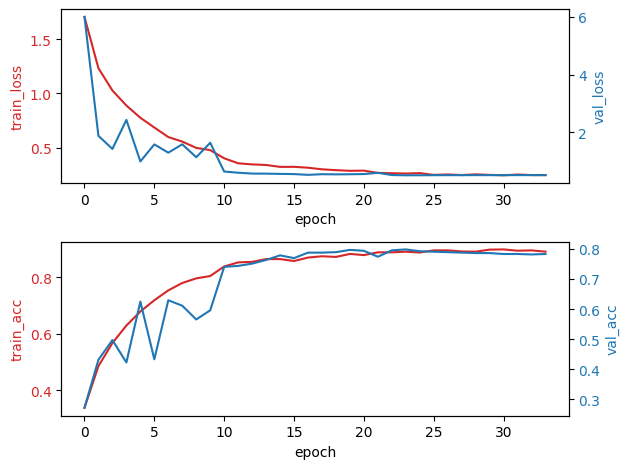

In [12]:
#path_model = conv_multi_class_5['path_model']
history = pkl.load(open(f"./models/vit/multi_class_5_4/history.pkl", "rb"))

ia_maker = IAFlow(models_folder='./test_moidels')
ia_maker.plot_history(history, f"./models/vit/multi_class_5_4/history.png")

In [ ]:
ia_maker = IAFlow(models_folder='./test_moidels')
ia_maker.plot_history(history, f"./models/vit/multi_class_5_4/history.png")

In [10]:
ia_maker.clear_session()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./models

## Evaluate models

In [10]:
BATCH_SIZE_EVA = 8
skip_models = [
    'vit/baseline', 'vit/mlp_1', 'vit/mlp_2', 'vit/mlp_3', 'vit/mlp_4', 'vit/mlp_5', 'vit/mlp_6',
    'vit/mlp_7', 'vit/multi_class', 'vit/multi_class_4', 'vit/multi_class_5', 'vit/multi_class_5_2',
    'vit/multi_class_5_3', 'vit/multi_class_5_4', 'vit/multi_class_5_5',
]
model_dataset = {
    'mlp_7': {
        'classes': 2,
        'amount': 1386,
        'path': './data/tfrecords/tf_dataset.tfrecord'
    },
    'multi_class': {
        'classes': 3,
        'amount': 2100,
        'path': './data/tfrecords/tf_dataset_3.tfrecord'
    },
    'multi_class_4': {
        'classes': 4,
        'amount': 2754,
        'path': './data/tfrecords/tf_dataset_4.tfrecord'
    },
    'multi_class_5': {
        'classes': 5,
        'amount': 3286,
        'path': './data/tfrecords/tf_dataset_5.tfrecord'
    },
    'multi_class_5_4': {
        'classes': 5,
        'amount': 3286,
        'path': './data/tfrecords/tf_dataset_5.tfrecord'
    }
}

In [ ]:
for model_name in os.listdir('./models/'):
      
    for run_id in os.listdir(f'./models/{model_name}'):
        need_skip = False
        for skip in skip_models:
            s_name, s_run = skip.split('/')
            if model_name == s_name and s_run == run_id:
                need_skip = True
                break

        if need_skip or run_id not in model_dataset.keys():
            continue

        amount_clasees = model_dataset.get(run_id).get('classes')
        tfrecord_path = model_dataset.get(run_id).get('path')
        all_items = model_dataset.get(run_id).get('amount')
        
        tf_dataset = load_tfrecord(tfrecord_path)

        train_size = int(all_items * 0.8)
        val_size = int(all_items - train_size)
        val_dataset = tf_dataset.skip(train_size)

        ia_maker.clear_session()
        result = ia_maker.get_model(model_name, run_id, False)
        if result is None or run_id in skip_models:
            continue

        model, run_id_data = result
        model_folder = run_id_data.get('path_model')
        metric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

        all_preds = []
        all_labels = []
        print(f'Predicting {model_name}/{run_id}')
        for images, label in val_dataset.batch(BATCH_SIZE_EVA):
            preds = model.predict(images, verbose=0)
            metric.update_state(label, preds)
            all_labels.extend(label.numpy())
            all_preds.extend(np.argmax(preds, axis=1))

        model = None
        val_dataset = None
        metric_result = metric.result().numpy()
        print('Predicting done, with accuracy: ', metric_result)
        metric.reset_states()
        ia_maker.clear_session()

        confusion_matrix= tf.math.confusion_matrix(all_labels, all_preds, num_classes=amount_clasees)
        plt.figure(figsize=(12, 12))
        sns.heatmap(confusion_matrix.numpy(), annot=True, cmap='Blues')
        plt.savefig(f'{model_folder}/confusion_matrix_test_{metric_result}.jpg')
        plt.show()

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
metrics_conv = './models/ConvTorch/baseline_2/metrics.csv'

metrics = pd.read_csv(metrics_conv)
metrics['epoch'] = metrics.index
metrics.columns

Index(['loss', 'acc', 'loss_test', 'acc_test', 'epoch'], dtype='object')

In [32]:
def smoth_line(_df, window=10):
  columns = _df.columns
  for column in columns:
    _df[column] = _df[column].rolling(window).mean()
  return _df

In [33]:
#df = smoth_line(metrics, 10)

In [34]:
idx_best_acc_test = metrics['acc_test'].idxmax()

print(f'Best loss: {metrics["loss"][idx_best_acc_test]:.2f}')
print(f'Best loss_test: {metrics["loss_test"][idx_best_acc_test]:.2f}')
print(f'Best acc: {metrics["acc"][idx_best_acc_test]:.2f}')
print(f'Best acc_test: {metrics["acc_test"][idx_best_acc_test]:.2f}')

Best loss: 1.09
Best loss_test: 1.13
Best acc: 0.81
Best acc_test: 0.77


<AxesSubplot: >

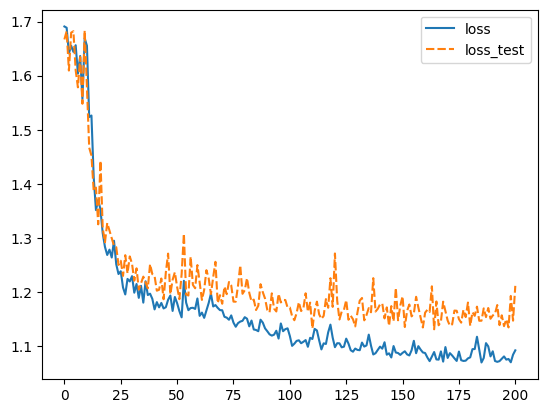

In [35]:
# loss and loss_test that is a array of numbers
sns.lineplot(metrics[['loss', 'loss_test']])


<AxesSubplot: >

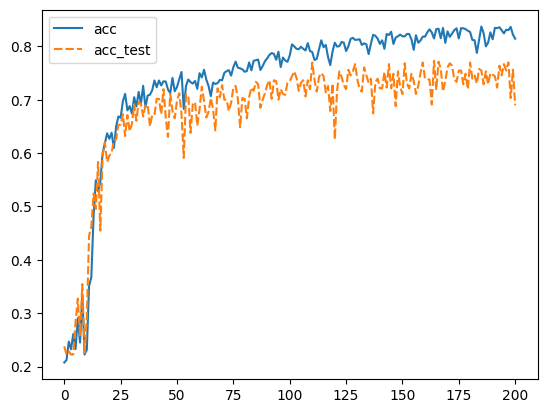

In [36]:
sns.lineplot(metrics[['acc', 'acc_test']])